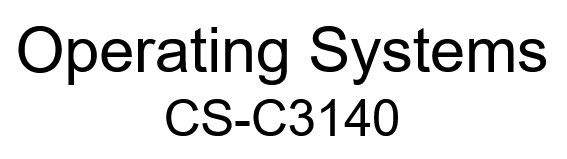

#Assignment 6: Writing a character device driver for Linux in C

Please enter the results in the [A+ platform](https://plus.cs.aalto.fi/accounts/login/?next=/os/2022/). For any questions please refer to the [Zulip chat of the OS course](https://operatingsystems.zulip.aalto.fi/).

>[Writing & testing a device driver](#scrollTo=u98TkQmORTck)

>>[Introduction](#scrollTo=xNnD8qZ4YXys)

>>[Character devices](#scrollTo=H_b2WJSRaNzd)

>>[C code for a Linux device driver](#scrollTo=ji5TZlSiglYq)

>[Build process](#scrollTo=Zi76LE3EOmFi)

>>[The Makefile](#scrollTo=Zi76LE3EOmFi)

>>[Module building and installing](#scrollTo=aJ_SGgs0pdxZ)

>[Testing the Driver](#scrollTo=-qYpGT8WNrcn)



The following code will work only if you have followed all the steps of the previous assignment (*Exercise 2 -- Preparing a Virtual Machine*). You can use the Text Editor in TinyCore to write the `Makefile` and a source file called `aaltodriver.c` file (or use `nano` after installing it; installation command is `$tce-load -wi nano`)

**Note**: For this exercise you have to use the TinyCore virtual machine which you created in the previous assignment.

**Note**: The following code is not meant to be run in Colab.

**Note**: You need to run `linux-kernel-sources-env.sh` again.

**Note**: The code below is based on the examples available in [Linux Device Drivers, Chapter 3](https://static.lwn.net/images/pdf/LDD3/ch03.pdf) and at [kernel.org](https://www.kernel.org/doc/html/v4.14/input/input-programming.html). For readability purposes, system calls are not explicitly handling error codes.

**Hint**: Use the `man` pages for any of the calls and methods below for a complete description of their functionality.

In [ ]:
! man exec

# Writing & testing a device driver

The kernel works as a middleware software for hardware and user programs. Kernel mode is generally reserved for low level trusted functions of the operating system. When the process is executing in user mode and if that process requires hardware resources such as RAM, printer etc, that process should send a request to the kernel. These requests are sent through **system calls**. Then the computer enters kernel mode from user mode. When the task is completed, the mode changes back to user mode from kernel mode. It is not possible to run all processes in the kernel mode because if a process fails the entire operating system might fail.

**Note**: You can find a discussion about user and kernel mode in in the lecture slides. The previous assignment included programming exercises about system calls.

The Linux Operating system has the *User Space* and the *Kernel Space*. User space runs all the **user applications**. For example, the GNU C Library (GlibC) implements a set of functions used by an application developer which meant to run in User space.

The Kernel space implements **device drivers, kernel modules and system calls**. Kernel space is not directly accessible from the user space but we can use system calls to create an interface between the two.

## Introduction



Programming a kernel module is different from user space
programming. A good approach would be to look for kernel modules doing something similar to what you intend and use that as a starting point. 

Kernels don’t use regular C libraries! None of the standard user space libraries are available from kernel code. For example, `printf()` is a user-level function and has no use to the kernel. The kernel will use a special `printk() `function to log events. 

## Character devices

Most of the Linux device drivers can be loaded on demand as kernel modules when they are needed and unloaded when they are no longer being used. Linux supports three types of hardware device: character, block and network.

A **character device** is any device that can have streams of characters read from or written to it. A character device has a character device driver associated with it that can be used for a device such as a line printer that handles one character at a time. 

Device-type information can be found using the ls command in /dev directory. The command


In [ ]:
!ls -l /dev/tty

crw-rw-rw- 1 root root 5, 0 Nov  1 08:49 /dev/tty


will output something like

```
crw-rw---- 1 root    root   4,64 Oct 13 10:23
```
We know this is a character device by the 'c' written at the first column of the output.

In UNIX, the devices traditionally had a unique, fixed identifier associated with them. This tradition is preserved in Linux. The identifier consists of two parts: **major** and **minor**. The numbers 4 and 64 (the numbers in the code cell might be different, such as `0, 5`) represent the major and the minor numbers of the device. 

A common major number is assigned to all devices that are being controlled by the same device driver. The minor number helps to distinguish between the exact device type/controller using the same device driver.

## C code for a Linux device driver

Write a simple Linux Kernel module that is able to create **two** character devices. 

We will run the following steps:
1. Create a single file called **aaltodriver.c** by merging the cells below and compile it using gcc.
2. After completing the **TODOs** and compiling the code, you need to build and load the module created and test your driver. 

First, we will import the (header files of the ) libraries we need:

In [ ]:
#include <linux/init.h>
#include <linux/module.h>
#include <linux/cdev.h>
#include <linux/device.h>
#include <linux/kernel.h>
#include <linux/uaccess.h>
#include <linux/fs.h>

We need to set the maximum number of devices we want to create:

In [ ]:
//1. TODO: replace ... with the number of minor devices we need to create in this exercise
#define MAX_DEVICE_NUM ...


Next, let's declare the device I/O functions we are going to use for our devices: 

In [ ]:
static int chdev_open(struct inode *inode, struct file *file);
static int chdev_release(struct inode *inode, struct file *file);
static long chdev_ioctl(struct file *file, unsigned int cmd, unsigned long arg);
static ssize_t chdev_read(struct file *file, char __user *buf, size_t count, loff_t *offset);
static ssize_t chdev_write(struct file *file, const char __user *buf, size_t count, loff_t *offset);

In the kernel, a character-type device is represented by `struct cdev`, a structure used to register it in the system. Most driver operations use three important structures: `struct file_operations`, `struct file` and `struct inode`.

The character device drivers receive unaltered system calls made by users over device-type files. Consequently, implementation of a character device driver means implementing the system calls specific to files: `open, close, read, write, lseek, mmap`, etc. These operations are described in the fields of the `struct file_operations` structure:


```
#include <linux/fs.h>

struct file_operations {
    struct module *owner;
    loff_t (*llseek) (struct file *, loff_t, int);
    ssize_t (*read) (struct file *, char __user *, size_t, loff_t *);
    ssize_t (*write) (struct file *, const char __user *, size_t, loff_t *);
    [...]
    long (*unlocked_ioctl) (struct file *, unsigned int, unsigned long);
    [...]
    int (*open) (struct inode *, struct file *);
    int (*flush) (struct file *, fl_owner_t id);
    int (*release) (struct inode *, struct file *);
    [...]
```

But not all of these operations need to be implemented by a driver.

We need to initialize the *struct file_operations* according to what type of device we write the driver for:

In [ ]:
// 2. TODO: initialize file operations by replacing ...
static const struct file_operations chdev_file_ops = {
    .owner      = THIS_MODULE,
    .open       = ...,
    .release    = ..., 
    .unlocked_ioctl = ...,
    .read       = ...,
    .write       = ...
};

// device data holder, this structure may be extended to hold additional data
struct mychar_device_data {
    struct cdev cdev;
};


// global storage for device major number
static int dev_major = 0;

// sysfs class structure
static struct class *chdev_class = NULL;

// array of mychar_device_data for our minor devices
static struct mychar_device_data chdev_data[MAX_DEVICE_NUM];

// configure UDEV variables to set correct permissions to the character device
static int chdev_uevent(struct device *dev, struct kobj_uevent_env *env)
{
    add_uevent_var(env, "DEVMODE=%#o", 0666);
    return 0;
}

The registration/unregistration of a device is made by specifying the `major` and `minor`.

The `dev_t` type is used to keep the identifiers of a device (both major and minor) and can be obtained using the `MKDEV` macro. It is recommended that device identifiers are dynamically assigned to the *alloc_chrdev_region* function.

Our `chdev_init` function should consist of the following steps:

1.  allocation and registration of the range of char device numbers using `alloc_chrdev_region`.
2.  get generated Major number, using `MAJOR()` macro
3.  call function class_create(THIS_MODULE, “chdev”) that creates sysfs class with paths for each of our character devices
4.  for each minor device, we need to: initialize the device, set the `owner` of the device, add the device to the system and create its node. 

In [ ]:
static int __init chdev_init(void)
{
    // declare variables
    int err, i;
    dev_t dev;
 
    // 3. TODO: allocate chardev region and assign Major number
    err = alloc_chrdev_region(..., ..., ..., "chdev");

    // to get generated Major number, we can use MAJOR() macro
    dev_major = MAJOR(dev);

    // create sysfs class
    chdev_class = class_create(THIS_MODULE, "chdev");
 
    // setting permissions
    chdev_class->dev_uevent = chdev_uevent;

    // create each minor device
    for (i = 0; i < MAX_DEVICE_NUM; i++) {
        
        // 4. TODO: initialize new device
        ...

        // 5. TODO: set the owner of the new device
        ...

        // 6. TODO: add device to the system where "i" is the minor number of the new device
        ...

        // 7. TODO: create device node /dev/chdev-x where "x" should be equal to the minor number
        device_create(..., NULL, ..., NULL, "chdev-%d", ...);
    }
    return 0;
}

If we no longer need the device, we must destroy it.

Our **chdev_exit** function should consist of the following steps:

1.  destroy each minor device 
2.  unregister created devices from system

In [ ]:
static void __exit chdev_exit(void)
{
    int i;
 
    // delete each minor device
    for (i = 0; i < MAX_DEVICE_NUM; i++) {
        // 8. TODO: add the right parameters to the device_destroy function
        device_destroy(..., ...);
    }

    class_unregister(chdev_class);
    class_destroy(chdev_class);

    unregister_chrdev_region(MKDEV(dev_major, 0), MINORMASK);
}


Now let's define the functions we previously declared to the *struct file_operations*. A driver for a device is the interface between an application and hardware. As a result, we often have to access a given user-space driver device. Accessing process address space can not be done directly (by de-referencing a user-space pointer).

Access is granted using the following functions:



1.   **copy_to_user** copies n bytes from the kernel-space, from the address referenced by *from* in user-space to the address referenced by *to*;
2.   **copy_from_user** copies n bytes from user-space from the address referenced by *from* in kernel-space to the address referenced by *to*.




In [ ]:
static int chdev_open(struct inode *inode, struct file *file)
{
    printk("CHDEV: Device open\n");
    return 0;
}

static int chdev_release(struct inode *inode, struct file *file)
{
    printk("CHDEV: Device close\n");
    return 0;
}

static long chdev_ioctl(struct file *file, unsigned int cmd, unsigned long arg)
{
    printk("CHDEV: Device ioctl\n");
    return 0;
}

static ssize_t chdev_read(struct file *file, char __user *buf, size_t count, loff_t *offset)
{
    uint8_t *data = "Hello from the kernel world!\n";
    size_t datalen = strlen(data);

    printk("Reading device: %d\n", MINOR(file->f_path.dentry->d_inode->i_rdev));

    if (count > datalen) {
        count = datalen;
    }

    if (copy_to_user(buf, data, count)) {
        return -EFAULT;
    }

    return count;
}

static ssize_t chdev_write(struct file *file, const char __user *buf, size_t count, loff_t *offset)
{
    size_t maxdatalen = 15, ncopied;
    uint8_t databuf[maxdatalen];

    printk("Writing device: %d\n", MINOR(file->f_path.dentry->d_inode->i_rdev));

    if (count < maxdatalen) {
        maxdatalen = count;
    }
 
    ncopied = copy_from_user(databuf, buf, maxdatalen);

    if (ncopied == 0) {
        printk("Copied %zd bytes from the user\n", maxdatalen);
    } else {
        printk("Couldn't copy %zd bytes from the user\n", ncopied);
    }

    databuf[maxdatalen] = 0;

    printk("Data from the user: %s\n", databuf);

    return count;
}


Now we can handle I/O requests. Great!

Finally, add `MODULE_LICENSE` and `MODULE_AUTHOR`.
You may be wondering why do we need this. Check [this](https://tldp.org/LDP/lkmpg/2.6/html/x279.html) out.

In [ ]:
MODULE_LICENSE("GPL");
MODULE_AUTHOR("Your Name Here");

module_init(chdev_init);
module_exit(chdev_exit);

# Build process

Assuming that you wrote your code in a file called `aaltodriver.c` and that you are using the TinyCore9 VM from the previous assignment, we can now start compiling the driver.


## The Makefile

You can use the following Makefile to build the module we just created. 

But what is a Makefile, anyway? check [this](https://opensource.com/article/18/8/what-how-makefile) to find out.

In [ ]:
BINARY      := aaltodriver
KERNEL      := /lib/modules/$(shell uname -r)/build
ARCH        := x86
C_FLAGS     := -Wall
KMOD_DIR    := $(shell pwd)
TARGET_PATH := /lib/modules/$(shell uname -r)/kernel/drivers/char

ccflags-y += $(C_FLAGS)

obj-m += $(BINARY).o

$(BINARY).ko:
    make -C $(KERNEL) M=$(KMOD_DIR) modules

install:
    cp $(BINARY).ko $(TARGET_PATH)
    depmod -a

uninstall:
    rm $(TARGET_PATH)/$(BINARY).ko
    depmod -a

clean:
    make -C $(KERNEL) M=$(KMOD_DIR) clean

## Module building and installing


* The following command builds and loads the module we just created. 

  9. TODO: Replace the ... with the right command parameter.
```
$ make && sudo insmod ...
```

  The **insmod** (insert module) command is a simple program to insert a module into the Linux Kernel. Similarly, the **rmmod** (remove module) command unloads the module.

  Tip: try to run 
```
$ lsmod
```
to check that your module was successfully loaded (should be called driver).


In [ ]:
!lsmod

Module                  Size  Used by
veth                   28672  0
xt_nat                 16384  10
cls_u32                24576  2
sch_htb                28672  1
xt_MASQUERADE          16384  1
xt_addrtype            16384  2
iptable_nat            16384  3
nf_nat                 61440  3 xt_nat,iptable_nat,xt_MASQUERADE
br_netfilter           24576  0
xt_state               16384  0
aesni_intel           368640  0
glue_helper            20480  1 aesni_intel
crypto_simd            16384  1 aesni_intel
cryptd                 24576  1 crypto_simd
virtio_balloon         24576  0
loadpin_trigger        12288  0
fuse                  147456  1
configfs               40960  1


* Check created devices using ls command. 

  10. TODO: Replace the ... with the right path in the `/dev` folder to both of your devices **at the same time** (consider using [wildcards](https://https://linuxhint.com/bash_wildcard_tutorial/) in file expressions).
```
$ ls -l ...
```

* Check build and load messages. 

  11. TODO: Read the device files from your `/dev `folder by replacing ... with the right path to either of the devices. 
```
$ cat ...
```



# Testing the Driver

We will test the read and write functions implemented above.

Character devices are presented as special files in a `/dev` directory and support direct reading and writing of any data, byte by byte, like a stream. Most of the pseudo-devices in /dev are character devices: serial ports, modems, sound, and video adapters, keyboards, etc. 

  12. TODO: write the following message: "Writing character device drivers is not that hard!" from device 0 and then read. After this, write the following message: "I do agree!" from device 1 and then read. 

  **Hint**: You may want to use the [dmesg](https://phoenixnap.com/kb/dmesg-linux) command for this task.